# Team Quantimize
## Overview of this notebook:
### Setup:
- Project structure
- Installation
### Usage:
- Data preparation
- Visualization
- Classic solutions
- Quantum solutions
- Air security
- Benchmarks
- Results and discussion

This notebook shall run without any errors or problems and should demonstrate the result of our work, as well as a comparision and a possible quantum advantage.

## Setup
### Project structure
The project is structured the following way:
Quantimize.ipynb is the main entry point. Every file has a brief explanation of what it contains and what it does.
- quantimize/:
    - classic/:
        - classic_solution.py: for the genetic algorithm (GA)
        - toolbox.py:for the straight line solution and various needed methods for the GA
    - data/:
        - aCCF_0623_p_spec.nc: the original atmospheric data file
        - atmo.json: the new created atmospheric data file
        - bada_data.csv: file containing information about the flight level/TAS/ROC/ROD and fuel consumption
        - bada_data.json: file containing the same information but in a different format
        - flights.csv: file containing information about all the flights (start, stop, FL)
        - flights.json: file containing the same information but in a different format
    - quantum/:
        - QGA.py: as the quantum genetic algorithm
        - quantum_solution.py: containing the QAOA algorithm
        - quantum_neural_network.py: containing the quantum neural network
        - toolbox.py: containing additional functions
    - air_security.py: for air security related checks
    - classic_summary.py: for calls to classic functions
    - converter.py: for conversion of units (kts->km/h, minutes->seconds)
    - create_json_data.py: to explain how we generated our datafiles
    - data_access.py: gives access to all the converted data and returns them
    - quantum_summary.py: for calls to quantum functions
    - visualisation.py: for all visualisation related functions
### Installation
The package can be cloned from github using 
```commandline
git clone https://
cd quantimize
```
After that, one needs to install all required packages using
```commandline
pip install requirements.txt
```
Now, everything should be ready and set up to further run this notebook.

## Usage
This section is dedicated to show how the notebook can be used and to show our work and results.
### Data preparation
The data preparation is all related to the file ```create_json_data.py```. It can be used as a standalone application to convert all three given files (atmospheric data, flight data, flight list) into the corresponding .json files. This was done to get a better handle over the files and to adapt the access to our purposes. For example, some flight levels were converted from hPa to FL for simpler calculations and visualisations on. Requirement for the file to run is, that there has to be a folder data (like in this project) in the current working directory. Also the files need to have the specific names for successful conversion. Further explanaition can be found in the file itself. We now want to concentrate more on the work done.
### Notebook preparation
Important imports to make this notebook work as expected

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

### Visualisation
Visualisation is done for a better understanding of the data and of course for nice pictures to look at. To use the visualisation, we first have to import the visualisation part of the package. Also the datetime package, because we need to work with time objects.

In [10]:
from quantimize import visualisation as vs
from datetime import time as t

We can now access all functions in it. As an example, we want to plot the atmospheric data of a certain flightlevel and time and see how it looks like. We choose FL = 295 and a time of 8 o'clock in the morning.

C:\Users\Franzi\Documents\QuantumClimateChallenge_2022\Quantum-Challenge\quantimize\visualisation.py:74: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs = map.pcolormesh(x,y,atmo_data[time_index][FL_index],vmin=-0.047278133046295995,vmax=0.34942841580572637)


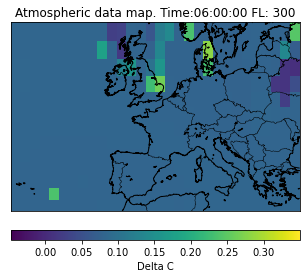

In [3]:
vs.make_atmo_map(295, t(8,0,0))

You will get the atmospheric data plotted in different colors, corresponding to the value and normalized to the min and max value available. In the title, you can also see, that there were some assumptions:
1. We have no atmospheric data for FL 295, so we choose the closest, which is FL 300
2. We also do not have atmospheric data for 8 o'clock in the morning. Therefore, we refer to 6 o'clock in the morning.

Regarding the time, we split the time in intervals from 6 to 9 corresponding to the data of 6 o'clock, 9 to 15 corresponding to the data of 12 o'clock and 15 to 21 corresponding to the data of 18 o'clock.

We also can animate the atmospheric data either for a fixed time variing in the FL or vice verca with a fixed FL variing in time. These function do not work in this notebook, because they are repetitive. To see the results, you need to import the package and run the code in a commandline. For completion it is shown here:

[100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 450, 500, 550, 600]


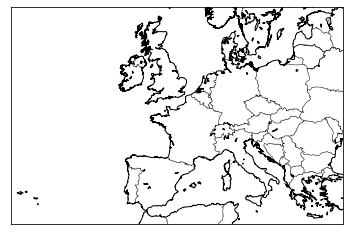

In [4]:
vs.make_animated_atmo_FL_map(t(12))

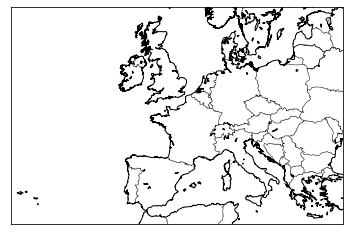

In [5]:
vs.make_animated_atmo_day_map(300)

Further visualisation will be presented, when showing flight paths.
### Classic solutions
In our work, we provide two different classic solutions. One being the simplest, the straight line solution, and the other being the genetic algorithm (GA).
#### Straight line solution
The straight line solution, as the name suggests, just computes a straight line from start to end, without any variation. The function takes the flight number (4) and a timestep dt, here 300 seconds, as input.

In [12]:
flight_nr = 17
dt = 300

In [13]:
import quantimize.classic_summary as classic_solution
trajectory_sls = classic_solution.straight_line_solution(flight_nr, dt)

The trajectory can now be plotted as a 2D graph for example. First we create a map and then plot the flight path.

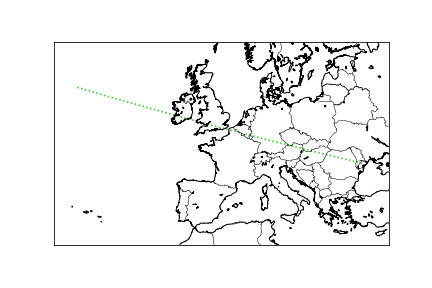

In [8]:
%matplotlib widget
map = vs.make_map()
vs.scatter_flight_path_on_map(map, trajectory_sls)

In the graph, you can see a dotted line showing the flight path. We can also now calculate the cost.

In [9]:
cost = classic_solution.compute_cost(trajectory_sls)
print(cost)

1793.3229766154702


The cost has the dimenstion 10e-12 K.

#### Genetic algorithm solution
In the genetic algorithm solution (GA) we use the genetic algorithm to find boundary points and then calculate from these points the optimal flight trajectory.

In [10]:
report, solution, trajectory_ga = classic_solution.genetic_algorithm_solution(flight_nr, dt)

 The best solution found:                                                                           
 [-16.55388072   0.90346721  12.07991779  53.10926452  49.69060399
  47.9850525  345.52383464 323.2405162  264.81311221 325.54130714
 341.42374806]

 Objective function:
 1291.5886770706893


The objective function also contains already the cost of this flight. We can now also plot this again, this time in 3D to see the flight level changes and the atmospheric data. The flight trajectory is also mapped to a uniform time distance for later calculations.

C:\Users\Franzi\Documents\QuantumClimateChallenge_2022\Quantum-Challenge\quantimize\visualisation.py:243: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.add_collection3d(map.pcolor(xb,yb,[[c1,c3],[c2,c4]],latlon=True,vmin=-0.047278133046295995,vmax=0.34942841580572637,alpha=0.3),zs=point[2])


(<Axes3DSubplot:>, <mpl_toolkits.basemap.Basemap at 0x1ff88adc2e0>)

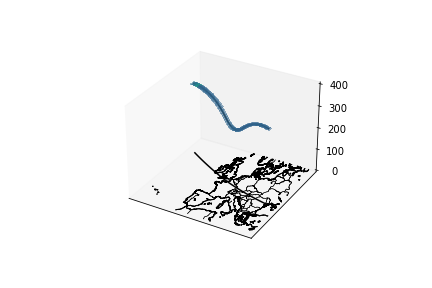

In [11]:
ax, map = vs.make_3d_map()
vs.plot_flight_path_on_map_3d_with_atmo_as_slices(ax, map, trajectory_ga)

The colors represent the value of the atmospheric data in squares around the flight path point. On the ground you can see the projection of the flight path. It clearly shows, that with variation in the flight height, one can obtain already a much better result than just staying on the same flight level. We can also check the cost, but these should be similar to the objective function.

In [12]:
cost = classic_solution.compute_cost(trajectory_ga)
print(cost)

1303.5299574125002


The small deviation comes from a different spacing of the points as mentioned above, but is in the same order as the original result.

### Quantum solution
Our quantum solutions consist of three different. The first is the quantum equivalent to the genetic algorithm. The second one ist a quantum neural network and the third one is a mapping of atmospheric data to a qubit grid.
#### Quantum genetic algortihm


In [13]:
import quantimize.quantum_summary as quantum_solution
trajectory_qga = quantum_solution.quantum_genetic_algorithm_solution(flight_nr, dt)

We can again plot this trajectory and compute its cost

C:\Users\Franzi\Documents\QuantumClimateChallenge_2022\Quantum-Challenge\quantimize\visualisation.py:243: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.add_collection3d(map.pcolor(xb,yb,[[c1,c3],[c2,c4]],latlon=True,vmin=-0.047278133046295995,vmax=0.34942841580572637,alpha=0.3),zs=point[2])


1300.97172475333


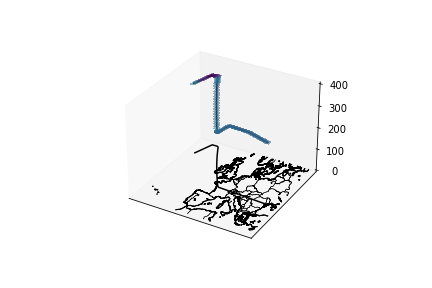

In [14]:
ax, map = vs.make_3d_map()
vs.plot_flight_path_on_map_3d_with_atmo_as_slices(ax, map, trajectory_qga)
cost = classic_solution.compute_cost(trajectory_qga)
print(cost)

As one can see, the algorithm gives an output, which is not as smooth as the classic solution. The climate efficiency is slightly better than for the classic GA.


#### Quantum neural network
The quantum neural network takes already precalculated boundary points and tries to optimize those further. We use the boundary points from the previous classic GA algorithm.

In [15]:
ctrl_pts = solution['variable']
optimized_ctrl_pts = quantum_solution.quantum_neural_network(flight_nr, 6, ctrl_pts)

Iteration = 2, Number of device executions = 2, Cost = 1347.863667820344
Iteration = 3, Number of device executions = 3, Cost = 1623.1488421965234
Iteration = 4, Number of device executions = 5, Cost = 1420.589375570835
Iteration = 5, Number of device executions = 6, Cost = 1326.9317775458758
Iteration = 6, Number of device executions = 8, Cost = 1682.6064048647822
Iteration = 7, Number of device executions = 9, Cost = 1333.7477757631195
Iteration = 8, Number of device executions = 11, Cost = 1628.743983963079
Iteration = 9, Number of device executions = 12, Cost = 1602.6292940189846
Iteration = 10, Number of device executions = 14, Cost = 1381.3197488475491
Iteration = 11, Number of device executions = 15, Cost = 1312.146754107498
Iteration = 12, Number of device executions = 17, Cost = 1693.6202029147491
Iteration = 13, Number of device executions = 18, Cost = 1711.4829139189808
Iteration = 14, Number of device executions = 20, Cost = 1405.3780607644096
Iteration = 15, Number of devi

In [16]:
print(optimized_ctrl_pts)

     fun: 1510.4089412001606
 message: 'terminated after reaching max number of iterations'
    nfev: 100
     nit: 50
 success: True
       x: array([  48.01964398, -461.86532035, -274.28854977, -242.7988269 ,
        -34.28491169,  -65.3606915 ,  -81.59750484,  306.37846986,
       -265.75686141, -269.00819345,   43.35595452,  172.53573595,
        400.60975175, -154.74957514,   29.22414647, -298.62587596,
        -70.31924758,  195.44383564,  -62.87326691, -265.59601773,
        134.63750013,  105.21533458,   70.8298565 ,  211.73037132,
        -29.40970802,   35.85047697, -404.21989523, -197.56843838,
         18.37885361,  305.37198042, -551.47115375, -235.14397391,
       -476.10493421,  108.78220113,  557.67305166,  -11.41621   ,
         54.22292585,  287.84547731,  228.84319151, -194.50623305,
       -162.71146453, -295.2237143 ,  -31.54067234,   -8.51446747,
       -180.921145  , -306.9013541 ,  249.22800876,  248.43354804,
       -505.73520555, -216.20295711,  248.5195152 , 

#### Qubit grid

In [17]:
gc = quantum_solution.sample_grid()
a,b,c = quantum_solution.run_QAOA(gc)

Cost function in Ising Hamiltonian form: -3.0*Z11*Z12 - 1.0*Z11*Z21 - 6.0*Z11 - 5.0*Z12*Z22 - 3.0*Z21*Z22 + 10.0*Z22
Cost function in QUBO form: -12.0*q11*q12 - 4.0*q11*q21 - 4.0*q11 - 20.0*q12*q22 + 16.0*q12 - 12.0*q21*q22 + 8.0*q21 + 36.0*q22 - 16.0


In [18]:
print(c)

[[ 1.  1.  1.  0.]
 [ 1.  1. -1. -1.]
 [ 1. -1. -1. -1.]
 [ 0. -1. -1. -1.]]


### Air security
Air security is essential for all planes in the air to avoid crashes and to save lives. After a flight trajectory is calculated, one has to check that the route has no steeper turns than 25°, that the plane is at least 10 FL above and below of other planes or has a distance of 5 nm (9,26 km) to the next plane. This can be checked with our air safety functions.

Since our code relys on timestamps, we first want do do an estimation of how close we have to choose our timesteps:
$\\s = 9.26km\\$
$v_{max} = 459kts = 850 km/h\\$
$t = \frac{s}{v_{max}} = 39,2 s\\$

To further enhance this, we reduce the time to 15 s. This fits good in a general scale of time(minutes) and provides us with enough points to detect possible collisions. Therefore we first adapt our trajectories:

In [31]:
import quantimize.air_security as air_safety
flights= [i for i in range(100)]
flights.remove(41)
trajectory_sls = []
trajectory_ga = []
for i in flights:
    if i != 41:
        trajectory_sls.append(classic_solution.straight_line_solution(i, 15))
        report, solution, trajectory_ga_tmp = classic_solution.genetic_algorithm_solution(i, 15)
        trajectory_ga.append(trajectory_ga_tmp)
    
#cost_sls = classic_solution.compute_cost(trajectory_sls)
#cost_ga = classic_solution.compute_cost(trajectory_ga)
#print(cost_sls, cost_ga)


 The best solution found:                                                                           
 [-17.36798403  -2.64476056   8.70010661  57.34110327  58.31350097
  58.96837421 353.90205556 321.75302178 327.49626612 321.62668872
 316.59295333]

 Objective function:
 1115.21821959622
 The best solution found:                                                                           
 [-15.67123818  -2.58264319  16.97803831  52.43626873  48.03287099
  44.13390075 369.74552939 335.77039603 344.48963272 334.30311071
 372.3128103 ]

 Objective function:
 1279.8086190505157
 The best solution found:                                                                           
 [ -9.90316006   5.62936208  19.33707728  36.28018989  40.20442005
  43.77159194 388.43979367 356.52216597 334.98773308 342.44379349
 326.60620544]

 Objective function:
 1131.960002876458
 The best solution found:                                                                           
 [-14.77129507  -0.71832222  

 The best solution found:                                                                           
 [-17.20611927  -2.71786603  12.67583029  53.77768899  56.20227383
  58.10785683 304.26432674 365.84534053 387.67563772 312.25905916
 388.90253199]

 Objective function:
 1074.3089084113133
 The best solution found:                                                                           
 [ -4.68758884   3.79752753  16.81423875  39.21269342  42.91452918
  49.37477379 377.93318317 339.94069377 328.64322302 315.8780307
 340.40157215]

 Objective function:
 1114.5017394148788
 The best solution found:                                                                           
 [-12.19049593   0.84582213  12.83283634  50.18617649  46.87225
  44.5726282  335.62684612 326.55795369 397.22383599 363.84822834
 314.51878083]

 Objective function:
 1291.228243295598
 The best solution found:                                                                           
 [ -8.97913632   5.12141169  16

 The best solution found:                                                                           
 [-12.88130822  -3.08913448  17.26515832  52.1971697   49.77343744
  44.91193503 337.91791851 322.60873082 359.21017866 351.02953697
 302.85789173]

 Objective function:
 1317.8932958942391
 The best solution found:                                                                           
 [-14.93121152   0.99429443  12.32047903  42.78258503  43.31704905
  43.57535826 343.2790534  347.66816151 365.09158925 355.44253975
 300.72353437]

 Objective function:
 1234.064581501693
 The best solution found:                                                                           
 [ -2.74386881   8.79849275  17.15708054  39.88226489  44.7739964
  49.81358838 368.22165262 394.3082993  299.82574021 336.72761146
 285.25820117]

 Objective function:
 1107.3100299888642
 The best solution found:                                                                           
 [-12.5260698    1.81857323 

 The best solution found:                                                                           
 [-1.26066444e+01 -2.27215686e-01  1.31531615e+01  3.81258315e+01
  4.48012281e+01  5.31693811e+01  3.92819760e+02  3.67504985e+02
  3.48152139e+02  3.36679240e+02  3.09321056e+02]

 Objective function:
 1194.61787413937
 The best solution found:                                                                           
 [-10.79632895   3.61318208  13.48443338  37.20126103  39.88599457
  42.30781602 343.20200754 341.42296083 361.17221705 342.81664084
 318.47900942]

 Objective function:
 1197.5630607149774
 The best solution found:                                                                           
 [-18.29341851  -4.64934418  12.39660818  43.59287727  53.32636084
  57.73055229 378.80095247 298.80198842 377.88172177 343.19693215
 308.50951038]

 Objective function:
 1250.4704938951156
 The best solution found:                                                                       

In [32]:
print(air_safety.check_safety(trajectory_sls, 15))

[(datetime.time(12, 49, 45), (23.924479599082133, 59.94832814674327, 250.0, 18), (23.835671923811837, 59.975655099822, 250.0, 68)), (datetime.time(12, 50), (23.954131264132236, 59.968616128093345, 250.0, 18), (23.874711569876965, 59.981438751090906, 250.0, 68)), (datetime.time(12, 50, 15), (23.98378292918234, 59.98890410944342, 250.0, 18), (23.913751215942092, 59.98722240235981, 250.0, 68))]


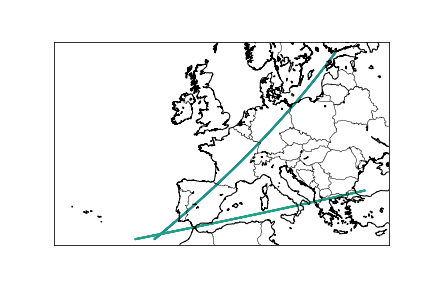

In [38]:
%matplotlib widget
map = vs.make_map()
vs.scatter_flight_path_on_map(map, trajectory_sls[18])
vs.scatter_flight_path_on_map(map, trajectory_sls[68])

In [37]:
for i in range(len(flights)):
    if air_safety.radius_control(trajectory_ga[i])==False:
        print('Radius problem of flight ', flights[i])


In [36]:
safety_errors_ga = air_safety.check_safety(trajectory_ga, 15)

[(datetime.time(6, 34, 45), (-25.260309278350515, 34.217611869919956, 313.4276293851152, 84), (-25.242021276595743, 34.1753275757917, 322.6617045974228, 86)), (datetime.time(6, 35), (-25.221649484536083, 34.22918422736139, 314.1053717705888, 84), (-25.20212765957447, 34.18451732406002, 322.7981364600166, 86)), (datetime.time(6, 35, 15), (-25.182989690721648, 34.24075658480282, 314.7831141560624, 84), (-25.16223404255319, 34.19370707232834, 322.9345683226105, 86)), (datetime.time(6, 35, 30), (-25.144329896907216, 34.25232894224425, 315.46085654153603, 84), (-25.122340425531913, 34.202896820596656, 323.07100018520435, 86)), (datetime.time(6, 35, 45), (-25.105670103092784, 34.26390129968567, 316.13859892700964, 84), (-25.08244680851064, 34.212086568864976, 323.2074320477982, 86)), (datetime.time(6, 36), (-25.067010309278352, 34.2754736571271, 316.81634131248325, 84), (-25.04255319148936, 34.2212763171333, 323.3438639103921, 86)), (datetime.time(6, 36, 15), (-25.028350515463917, 34.2870460

## Benchmarks

In [2]:
import quantimize.benchmarking.toolbox as bt
import quantimize.benchmarking.benchmarking as bb

### Benchmarking of computation time

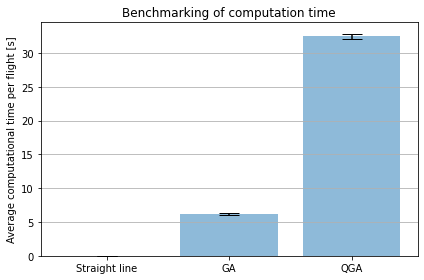

In [4]:
bt.plot_graph('Benchmarking of computation time','Average computational time per flight [s]', Mean_comp_time, Error_comp_time)

### Benchmarking of climate cost

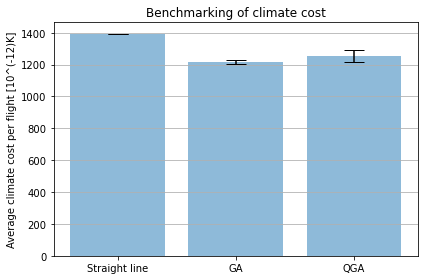

In [5]:
bt.plot_graph('Benchmarking of climate cost','Average climate cost per flight [10^(-12)K]', Mean_cost, Error_cost)

### Benchmarking of flight time

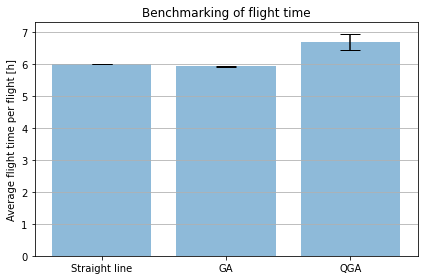

In [6]:
bt.plot_graph('Benchmarking of flight time','Average flight time per flight [h]', Mean_flight_time/3600, Error_flight_time/3600)

### Benchmarking of fuel consumption

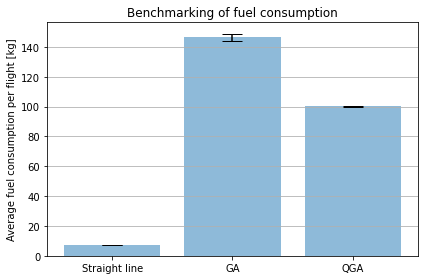

In [7]:
bt.plot_graph('Benchmarking of fuel consumption','Average fuel consumption per flight [kg]', Mean_fuel, Error_fuel)